# Natural language processing
Sarcasm classifier 

## Importing Module

In [1]:
import os
import json
import urllib

import numpy as np
import pandas as pd

import tensorflow as tf

from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## Problem
- Build and train a classifier for the sarcasm dataset.
- The classifier should have a final layer with `1` neuron activated by sigmoid.
- Do not use lambda layers in your model.
- Dataset used in this problem is built by Rishabh Misra (https://rishabhmisra.github.io/publications).
- Desired accuracy and validation_accuracy > `75%`

### Preparing data

In [3]:
data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sarcasm.json'
json_file = 'sarcasm.json'

if os.path.isfile(json_file) == False:
  urllib.request.urlretrieve(data_url, json_file)
  print(f'{json_file} Downloaded')
else:
  print(f'{json_file} Already exist')

sarcasm.json Downloaded


#### Explore data

Check data

In [4]:
json_path = './sarcasm.json'
with open(json_path, 'r') as f:
  datastore = json.load(f)

print(f'Total Data : {len(datastore)}')
print(f'List column : {datastore[0].keys()}')

Total Data : 26709
List column : dict_keys(['article_link', 'headline', 'is_sarcastic'])


Convert to DataFrame

In [5]:
sarcasm = pd.DataFrame(datastore)
sarcasm.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


More information about data

In [6]:
sarcasm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


Visualize Category 

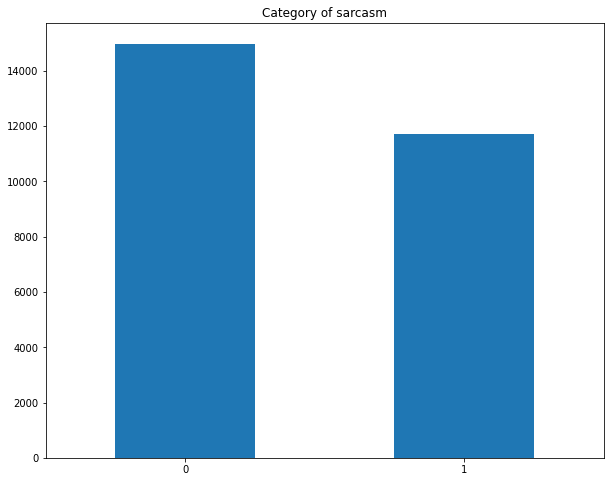

In [7]:
sarcasm['is_sarcastic'].value_counts().plot(kind='bar', figsize=(10,8), rot=0, title='Category of sarcasm')
plt.show()

### Preparing Model

Set Paramters

In [8]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

filter = '!"#$%&()*+.,-/:;=?@[\]^_`{|}'

#### Split Data

In [9]:
def train_val_split(sentences, labels, training_split):
  """
  Splits the dataset into training and validation sets
    
  Args:
      sentences (list of string): lower-cased sentences without stopwords
      labels (list of string): list of labels
      training split (float): proportion of the dataset to convert to include in the train set
    
  Returns:
      train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
  """

  # Compute the number of sentences that will be used for training (should be an integer)
  train_size = training_split

  # Split the sentences and labels into train/validation splits
  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]

  validation_sentences = sentences[train_size:]
  validation_labels = labels[train_size:]
    
    
  return train_sentences, validation_sentences, train_labels, validation_labels

In [10]:
sentences = sarcasm['headline']
labels = sarcasm['is_sarcastic']

train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, training_size)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 20000 sentences for training.

There are 20000 labels for training.

There are 6709 sentences for validation.

There are 6709 labels for validation.


#### Tokenizer

In [11]:
def fit_tokenizer(sentences, num_words, oov_token, filter):
  """
  Instantiates the Tokenizer class on the training sentences
    
  Args:
      sentences (list of string): lower-cased sentences without stopwords to be used for training
      num_words (int) - number of words to keep when tokenizing
      oov_token (string) - symbol for the out-of-vocabulary token
    
  Returns:
      tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
  """
  # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters=filter)

   # Fit the tokenizer to the training sentences
  tokenizer.fit_on_texts(sentences)
  
  return tokenizer

In [12]:
tokenizer = fit_tokenizer(train_sentences, vocab_size, oov_tok, filter)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 25638 words

<OOV> token included in vocabulary


#### Convert text to Sequence and Add Padding

In [13]:
def seq_and_pad(sentences, tokenizer, maxlen, padding='pre', truncating='pre'):
  """
  Generates an array of token sequences and pads them to the same length
    
  Args:
      sentences (list of string): list of sentences to tokenize and pad
      tokenizer (object): Tokenizer instance containing the word-index dictionary
      padding (string): type of padding to use
      maxlen (int): maximum length of the token sequence
    
  Returns:
      padded_sequences (array of int): tokenized sentences padded to the same length
  """  
  # Convert sentences to sequences
  sequences = tokenizer.texts_to_sequences(sentences)
    
  # Pad the sequences using the correct padding and maxlen
  padded_sequences = pad_sequences(sequences, 
                                   maxlen=maxlen, 
                                   padding=padding,
                                   truncating=truncating)

  return padded_sequences

In [14]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, max_length, padding=padding_type, truncating=trunc_type)
test_padded_seq = seq_and_pad(val_sentences, tokenizer, max_length, truncating=trunc_type)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {test_padded_seq.shape}")

Padded training sequences have shape: (20000, 120)

Padded validation sequences have shape: (6709, 120)


In [15]:
train_labels = np.array(train_labels)
test_labels = np.array(val_labels)

#### Build Model

In [16]:
def build_model(num_words, embedding_dim, maxlen):
  """
  Creates a text classifier model
    
  Args:
      num_words (int): size of the vocabulary for the Embedding layer input
      embedding_dim (int): dimensionality of the Embedding layer output
      maxlen (int): length of the input sequences
    
  Returns:
      model (tf.keras Model): the text classifier model
  """

  # Define Params  
  lr = 1e-3
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.SparseCategoricalCrossentropy()

  # Define Activation Function
  relu = tf.nn.relu
  softmax = tf.nn.softmax

  # Define model sequential
  model = tf.keras.Sequential()

  # Define layer for Embedding text
  model.add(tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen))

  # Flatten layers and add Dropout
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dropout(0.4))

  # Define fully connected layers
  model.add(tf.keras.layers.Dense(24, activation=relu))
  model.add(tf.keras.layers.Dense(5, activation=softmax))

  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['accuracy'])

  # Check Summary Model
  model.summary()

  print('\nModel Succesfully Create')
  
  return model

#### Define Callbacks

In [17]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=8, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

### Train Model

In [18]:
model = build_model(vocab_size, embedding_dim, max_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 5)                 125       
                                                                 
Total params: 16,533
Trainable params: 16,533
Non-trainable params: 0
____________________________________________________

In [19]:
history = model.fit(train_padded_seq, train_labels, 
                    epochs=30,
                    validation_data=(test_padded_seq, test_labels),
                    validation_steps=30,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/30
620/625 [============================>.] - ETA: 0s - loss: 0.7954 - accuracy: 0.5392
Epoch 1: val_accuracy improved from -inf to 0.56327, saving model to model.h5
625/625 [==============================] - 5s 3ms/step - loss: 0.7947 - accuracy: 0.5388 - val_loss: 0.6872 - val_accuracy: 0.5633
Epoch 2/30
611/625 [============================>.] - ETA: 0s - loss: 0.6863 - accuracy: 0.5614
Epoch 2: val_accuracy did not improve from 0.56327
625/625 [==============================] - 2s 3ms/step - loss: 0.6861 - accuracy: 0.5621 - val_loss: 0.6798 - val_accuracy: 0.5633
Epoch 3/30
623/625 [============================>.] - ETA: 0s - loss: 0.6773 - accuracy: 0.5707
Epoch 3: val_accuracy improved from 0.56327 to 0.56417, saving model to model.h5
625/625 [==============================] - 2s 3ms/step - loss: 0.6773 - accuracy: 0.5706 - val_loss: 0.6600 - val_accuracy: 0.5642
Epoch 4/30
618/625 [============================>.] - ETA: 0s - loss: 0.6264 - accuracy: 0.6516
Epoch 4: val_

### Visualization result

In [20]:
def visualize_result(history):
  '''Function for Visual result'''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

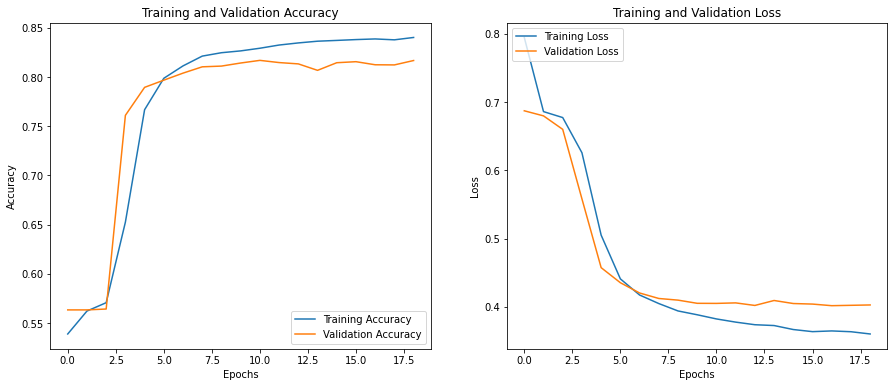

In [21]:
visualize_result(history)

### Download Model

In [ ]:
from google.colab import files
files.download('model.h5')